In [1]:
#The beginning is code from Bovee's parser: 
#https://github.com/jbovee/j-archive-parser
from bs4 import BeautifulSoup
import re
import os
import sys
import time
import requests
import concurrent.futures as futures

In [8]:
CURRENT_DIR = os.path.dirname(os.path.abspath(__file__))
SITE_FOLDER = os.path.join(CURRENT_DIR, 'j-archive archive')
NUM_THREADS = 2
try:
	import multiprocessing
	NUM_THREADS = multiprocessing.cpu_count() * 2
	print('Using {} threads'.format(NUM_THREADS))
except (ImportError, NotImplementedError):
	pass

def main():
	create_save_folder()
	seasons = list(range(1,36))
	with futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
		for season in seasons:
			f = executor.submit(download_season, season)
            

def current():
	create_save_folder()
	seasons = [36]
	with futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
		for season in seasons:
			f = executor.submit(download_season, season)

def create_save_folder():
	if not os.path.isdir(SITE_FOLDER):
		sys_print("Creating {} folder".format(SITE_FOLDER))
		os.mkdir(SITE_FOLDER)

Using 12 threads


In [7]:
[36]

[36]

In [4]:
def download_season(season):
	sys_print('Downloading Season {}'.format(season))
	season_folder = os.path.join(SITE_FOLDER, "season {}".format(season))
	if not os.path.isdir(season_folder):
		sys_print("Creating season {} folder".format(season))
		os.mkdir(season_folder)
	seasonPage = requests.get('http://j-archive.com/showseason.php?season={}'.format(season))
	seasonSoup = BeautifulSoup(seasonPage.text, 'lxml')
	epIdRe = re.compile(r'game_id=(\d+)')
	epNumRe = re.compile(r'\#(\d{1,4})')
	episodeRe = re.compile(r'http:\/\/www\.j-archive\.com\/showgame\.php\?game_id=[0-9]+')
	episodeLinks = [link for link in seasonSoup.find_all('a') if episodeRe.match(link.get('href'))][::-1]
	for link in episodeLinks:
		episodeNumber = epNumRe.search(link.text.strip()).group(1)
		gameFile = os.path.join(season_folder,'{}.html'.format(episodeNumber))
		if not os.path.isfile(gameFile):
			episodeId = epIdRe.search(link['href']).group(1)
			gamePage = requests.get('http://j-archive.com/showgame.php?game_id={}'.format(episodeId))
			open(gameFile, 'wb').write(gamePage.content)
			time.sleep(5)
	sys_print('Season {} finished'.format(season))

def sys_print(string):
	sys.stdout.write("{}\n".format(string))
	sys.stdout.flush()

In [5]:
if __name__=="__main__":
	main()

Creating season 1 folder
Creating season 3 folder
Creating season 4 folder
Creating season 2 folder
Creating season 5 folder
Creating season 6 folder
Creating season 7 folder
Creating season 8 folder
Creating season 11 folder
Creating season 10 folder
Creating season 12 folder
Creating season 9 folder
Season 1 finished
Creating season 13 folder
Season 10 finished
Creating season 14 folder
Season 11 finished
Creating season 15 folder
Season 2 finished
Creating season 16 folder
Season 7 finished
Creating season 17 folder
Season 8 finished
Creating season 18 folder
Season 9 finished
Creating season 19 folder
Season 12 finished
Creating season 20 folder
Season 3 finished
Creating season 21 folder
Season 5 finished
Creating season 22 folder
Season 6 finished
Creating season 23 folder
Season 4 finished
Creating season 24 folder
Season 13 finished
Creating season 25 folder
Season 15 finished
Creating season 26 folder
Season 14 finished
Creating season 27 folder
Season 16 finished
Creating sea

In [9]:
if __name__=="__main__":
	current()

Creating season 36 folder
Season 36 finished


In [11]:
#j-archive-parser.py
from __future__ import print_function
from bs4 import BeautifulSoup
import time
import lxml
import sys
import os
import re
import csv
#import progressbar
import concurrent.futures as futures

In [13]:
# Break up CSVs into seasons

CURRENT_DIR = os.path.dirname(os.path.abspath("__file__"))
SITE_FOLDER = os.path.join(CURRENT_DIR, "j-archive archive")
SAVE_FOLDER = os.path.join(CURRENT_DIR, "j-archive-csv")
NUM_THREADS = 2
try:
	import multiprocessing
	NUM_THREADS = multiprocessing.cpu_count() * 2
	print('Using {} threads'.format(NUM_THREADS))
except (ImportError, NotImplementedError):
	pass

Using 12 threads


In [14]:
def main():
	create_save_folder()
	get_all_seasons()

#Create a folder, if there isn't already one, to save season csv's in
def create_save_folder():
    if not os.path.isdir(SAVE_FOLDER):
        print("Creating {} folder".format(SAVE_FOLDER))
        os.mkdir(SAVE_FOLDER)

In [15]:
#Get a list of all seasons from the list season page. Then iterate through list, parsing
#each season (using multithreading to have, typically, four seasons being parsed at once.)
def get_all_seasons():
	seasons = sorted([int(re.search(r'(\d+)', d).group(1)) for d in os.listdir(SITE_FOLDER) if os.path.isdir(os.path.join(SITE_FOLDER, d))])

	with futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
		for season in seasons:
			f = executor.submit(parse_season, season)
            
def parse_season(season):
	print('Starting season {}'.format(season))
	season_folder = os.path.join(SITE_FOLDER, 'season {}'.format(season))
	files = [os.path.join(season_folder, f) for f in os.listdir(season_folder) if os.path.isfile(os.path.join(season_folder, f))]

	#Name and set up path for csv file in created folder using the name/number of season
	saveFile = os.path.join(SAVE_FOLDER, 'j-archive-season-{}.csv'.format(season))

	#Create csv file in write mode with utf-8 encoding
	with open(saveFile,'w',newline='',encoding='utf-8') as csvfile:
		#Set up csv writer
		episodeWriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
		#Write titles to csv file
		episodeWriter.writerow(['epNum', 'airDate', 'extra_info', 'round_name', 'coord', 'category', 'order', 'value', 'daily_double', 'question', 'answer', 'correctAttempts', 'wrongAttempts'])
		for file_i in range(len(files)):
			print('\rSeason {}: Parsing episode {}/{}'.format(season,file_i,len(files)), flush=True)
			ep = parse_episode(files[file_i])
			if ep:
				ep = [[[clueElement for clueElement in clue] for clue in round] for round in ep]
				for round in ep:
					for question in round:
						episodeWriter.writerow(question)
	print('Season {} complete'.format(season))
    
def parse_episode(episodeLink):
	#Get episode page
	episode = open(episodeLink, encoding="utf-8")
	soupEpisode = BeautifulSoup(episode, 'lxml')
	episode.close()

	#Get episode number (different from ID) from page title
	epNum = re.search(r'#(\d+)', soupEpisode.title.text).group(1)
	#Get extra info about episode from top of page
	extraInfo = soupEpisode.find('div', id='game_comments').text
	#Check for special season names (Super Jeopardy, Trebek Pilots, anything non-number)
	sj = re.compile(r'(Super Jeopardy!) show #(\d+)')
	if sj.search(soupEpisode.title.text):
		epNum = ' '.join(sj.search(soupEpisode.title.text).groups())
	trbk = re.compile(r'(Trebek pilot) #(\d+)')
	if trbk.search(soupEpisode.title.text):
		epNum = ' '.join(trbk.search(soupEpisode.title.text).groups())
	#Get episode air date from page title (format YYYY-MM-DD)
	airDate = re.search(r'[0-9]{4}-[0-9]{2}-[0-9]{2}', soupEpisode.title.text).group()

	#Booleans to check if page has each round type
	hasRoundJ = True if soupEpisode.find(id='jeopardy_round') else False
	hasRoundDJ = True if soupEpisode.find(id='double_jeopardy_round') else False
	hasRoundFJ = True if soupEpisode.find(id='final_jeopardy_round') else False
	hasRoundTB = True if len(soupEpisode.find_all(class_='final_round')) > 1 else False

	parsedRounds = []

	#For each round type, if exists in page, parse
	if hasRoundJ:
		j_table = soupEpisode.find(id='jeopardy_round')
		#Pass epNum and airDate to so all info can be added into array as a question at once
		parsedRounds.append(parse_round(0, j_table, epNum, airDate, extraInfo))

	if hasRoundDJ:
		dj_table = soupEpisode.find(id='double_jeopardy_round')
		#Pass epNum and airDate to so all info can be added into array as a question at once
		parsedRounds.append(parse_round(1, dj_table, epNum, airDate, extraInfo))

	if hasRoundFJ:
		fj_table = soupEpisode.find(id='final_jeopardy_round').find_all(class_='final_round')[0]
		#Pass epNum and airDate to so all info can be added into array as a question at once
		parsedRounds.append(parse_round(2, fj_table, epNum, airDate, extraInfo))
	
	if hasRoundTB:
		tb_table = soupEpisode.find(id='final_jeopardy_round').find_all(class_='final_round')[1]
		parsedRounds.append(parse_round(3, tb_table, epNum, airDate, extraInfo))

	#Some episodes have pages, but don't have any actual episode content in them
	if parsedRounds:
		return parsedRounds
	else:
		return None


In [16]:
#Parse a single round layout (Jeopardy, Double Jeopardy, Final Jeopardy)
#Final is different than regular and double. Only has a single clue, and has multiple responses and bets.
def parse_round(round, table, epNum, airDate, extraInfo):
	roundClues = []
	if round < 2:
		#Get list of category names
		categories = [cat.text for cat in table.find_all('td', class_='category_name')]
		#Variable for tracking which column (category) currently getting clues from
		x = 0
		for clue in table.find_all('td', class_='clue'):
			exists = True if clue.text.strip() else False
			if exists:
				#Clue text <td> has id attribute in the format clue_round_x_y, one indexed
				#Extract coordinates from id text
				coord = tuple([int(x) for x in re.search(r'(\d)_(\d)', clue.find('td', class_='clue_text').get('id')).groups()])
				valueRaw = clue.find('td', class_=re.compile('clue_value')).text
				#Strip down value text to just have number (daily doubles have DD:)
				try:
					value = (int(valueRaw.lstrip('D: $').replace(',','')),)
				except:
					value = (-100,)
				question = clue.find('td', class_='clue_text').text
				#Answers to questions (both right and wrong) are in hover, each with a class to specify color
				answer = BeautifulSoup(clue.find('div', onmouseover=True).get('onmouseover'), 'lxml').find('em', class_='correct_response').text
				daily_double = True if re.match(r'DD:', valueRaw) else False
				wrong = BeautifulSoup(clue.find('div', onmouseover=True).get('onmouseover'), 'lxml').find_all('td', class_='wrong')
				n = len(wrong)
				for w in wrong:
					#Sometimes instead of showing all three incorrect responses will just show 'Triple Stumper'
					#(also sometimes has 'Triple Stumper' as well as other wrong responses)
					if re.match(r'Triple Stumper', w.text):
						n = 3
				wrongAttempts = n
				#Some odd situations with more than one correct response
				correctAttempts = len(BeautifulSoup(clue.find('div', onmouseover=True).get('onmouseover'), 'lxml').find_all('td', class_='right'))
				#Doesn't actually get used
				totalAttemps = wrongAttempts + correctAttempts
				order = clue.find('td', class_='clue_order_number').text
				category = categories[x]
				round_name = 'Jeopardy' if round == 0 else 'Double Jeopardy'
				#Add all retrieved data onto array
				roundClues.append([epNum, airDate, extraInfo, round_name, coord, category, order, value, daily_double, question, answer, correctAttempts, wrongAttempts])
			#Tracking current column
			x = 0 if x == 5 else x + 1
	elif round == 2:
		#Final Jeopardy
		coord = (1,1)
		rawValue = [x.text for x in BeautifulSoup(table.find('div', onmouseover=True).get('onmouseover'), 'lxml').find_all(lambda tag: tag.name == 'td' and not tag.attrs)]
		value = tuple([int(v.lstrip('D: $').replace(',','')) for v in rawValue])
		question = table.find('td', id='clue_FJ').text
		answer = BeautifulSoup(table.find('div', onmouseover=True).get('onmouseover'), 'lxml').find('em').text
		daily_double = False
		wrongAttempts = len(BeautifulSoup(table.find('div', onmouseover=True).get('onmouseover'), 'lxml').find_all('td', class_='wrong'))
		correctAttempts = len(BeautifulSoup(table.find('div', onmouseover=True).get('onmouseover'), 'lxml').find_all('td', class_='right'))
		totalAttemps = wrongAttempts + correctAttempts
		order = 0
		category = table.find('td', class_='category_name').text
		round_name = 'Final Jeopardy'
		roundClues.append([epNum, airDate, extraInfo, round_name, coord, category, order, value, daily_double, question, answer, correctAttempts, wrongAttempts])
	else:
		#Tiebreaker round
		coord = (1,1)
		value = ()
		question = table.find('td', id='clue_TB').text
		answer = BeautifulSoup(table.find('div', onmouseover=True).get('onmouseover'), 'lxml').find('em').text
		daily_double = False
		wrongAttempts = len(BeautifulSoup(table.find('div', onmouseover=True).get('onmouseover'), 'lxml').find_all('td', class_='wrong'))
		correctAttempts = len(BeautifulSoup(table.find('div', onmouseover=True).get('onmouseover'), 'lxml').find_all('td', class_='right'))
		totalAttemps = wrongAttempts + correctAttempts
		order = 0
		category = table.find('td', class_='category_name').text
		round_name = 'Tiebreaker'
		roundClues.append([epNum, airDate, extraInfo, round_name, coord, category, order, value, daily_double, question, answer, correctAttempts, wrongAttempts])
	return roundClues

In [17]:
if __name__ == "__main__":
	main()

Starting season 1
Starting season 2
Starting season 3
Starting season 4
Starting season 5
Starting season 6
Starting season 7
Starting season 8
Starting season 9
Starting season 10
Starting season 11
Starting season 12
Season 1: Parsing episode 0/45
Season 2: Parsing episode 0/64
Season 11: Parsing episode 0/57
Season 8: Parsing episode 0/82

Season 10: Parsing episode 0/60
Season 3: Parsing episode 0/132

Season 12: Parsing episode 0/112
Season 5: Parsing episode 0/137
Season 4: Parsing episode 0/159
Season 6: Parsing episode 0/160
Season 2: Parsing episode 1/64
Season 1: Parsing episode 1/45
Season 3: Parsing episode 1/132
Season 4: Parsing episode 1/159
Season 5: Parsing episode 1/137
Season 8: Parsing episode 1/82
Season 11: Parsing episode 1/57
Season 7: Parsing episode 1/69
Season 9: Parsing episode 1/90
Season 10: Parsing episode 1/60
Season 6: Parsing episode 1/160
Season 12: Parsing episode 1/112
Season 1: Parsing episode 2/45
Season 2: Parsing episode 2/64
Season 5: Parsing e

Season 11: Parsing episode 40/57
Season 8: Parsing episode 42/82
Season 12: Parsing episode 40/112
Season 10: Parsing episode 41/60
Season 3: Parsing episode 41/132
Season 7: Parsing episode 49/69
Season 5: Parsing episode 41/137
Season 4: Parsing episode 41/159
Season 1 complete
Starting season 13
Season 6: Parsing episode 40/160
Season 13: Parsing episode 0/208
Season 2: Parsing episode 44/64
Season 9: Parsing episode 40/90
Season 11: Parsing episode 41/57
Season 8: Parsing episode 43/82
Season 12: Parsing episode 41/112
Season 3: Parsing episode 42/132
Season 10: Parsing episode 42/60
Season 7: Parsing episode 50/69
Season 5: Parsing episode 42/137
Season 4: Parsing episode 42/159
Season 6: Parsing episode 41/160
Season 13: Parsing episode 1/208
Season 2: Parsing episode 45/64
Season 9: Parsing episode 41/90
Season 11: Parsing episode 42/57
Season 8: Parsing episode 44/82
Season 3: Parsing episode 43/132
Season 12: Parsing episode 42/112
Season 7: Parsing episode 51/69
Season 5: Par

Season 17: Parsing episode 0/230
Season 16: Parsing episode 1/230
Season 3: Parsing episode 63/132
Season 5: Parsing episode 62/137
Season 6: Parsing episode 60/160
Season 15: Parsing episode 2/228
Season 14: Parsing episode 4/229
Season 12: Parsing episode 61/112
Season 12: Parsing episode 62/112
Season 9: Parsing episode 60/90
Season 13: Parsing episode 20/208
Season 8: Parsing episode 63/82
Season 17: Parsing episode 1/230
Season 4: Parsing episode 63/159
Season 16: Parsing episode 2/230
Season 3: Parsing episode 64/132

Season 6: Parsing episode 61/160
Season 15: Parsing episode 3/228
Season 14: Parsing episode 5/229
Season 3: Parsing episode 65/132
Season 12: Parsing episode 63/112
Season 9: Parsing episode 61/90
Season 13: Parsing episode 21/208
Season 4: Parsing episode 64/159
Season 5: Parsing episode 64/137
Season 16: Parsing episode 3/230
Season 8: Parsing episode 64/82
Season 17: Parsing episode 2/230
Season 6: Parsing episode 62/160
Season 15: Parsing episode 4/228
Season 1

Season 18: Parsing episode 0/229
Season 12: Parsing episode 81/112
Season 6: Parsing episode 80/160
Season 9: Parsing episode 79/90
Season 13: Parsing episode 40/208
Season 5: Parsing episode 86/137
Season 4: Parsing episode 84/159
Season 14: Parsing episode 25/229
Season 16: Parsing episode 22/230
Season 17: Parsing episode 20/230
Season 3: Parsing episode 84/132
Season 15: Parsing episode 23/228
Season 18: Parsing episode 1/229
Season 12: Parsing episode 82/112
Season 6: Parsing episode 81/160
Season 9: Parsing episode 80/90
Season 13: Parsing episode 41/208
Season 5: Parsing episode 87/137
Season 4: Parsing episode 85/159
Season 16: Parsing episode 23/230
Season 14: Parsing episode 26/229
Season 17: Parsing episode 21/230
Season 3: Parsing episode 85/132
Season 15: Parsing episode 24/228
Season 18: Parsing episode 2/229
Season 12: Parsing episode 83/112
Season 6: Parsing episode 82/160
Season 5: Parsing episode 88/137
Season 9: Parsing episode 81/90
Season 13: Parsing episode 42/208

Season 4: Parsing episode 104/159
Season 19: Parsing episode 8/228
Season 17: Parsing episode 39/230
Season 18: Parsing episode 20/229
Season 16: Parsing episode 42/230
Season 15: Parsing episode 43/228
Season 13: Parsing episode 60/208
Season 5: Parsing episode 107/137
Season 6: Parsing episode 100/160
Season 3: Parsing episode 105/132
Season 14: Parsing episode 46/229
Season 4: Parsing episode 105/159
Season 12: Parsing episode 103/112
Season 19: Parsing episode 9/228
Season 17: Parsing episode 40/230
Season 15: Parsing episode 44/228
Season 16: Parsing episode 43/230
Season 18: Parsing episode 21/229
Season 13: Parsing episode 61/208
Season 5: Parsing episode 108/137
Season 3: Parsing episode 106/132
Season 6: Parsing episode 101/160
Season 14: Parsing episode 47/229
Season 4: Parsing episode 106/159
Season 12: Parsing episode 104/112
Season 19: Parsing episode 10/228
Season 17: Parsing episode 41/230
Season 15: Parsing episode 45/228
Season 16: Parsing episode 44/230
Season 18: Par

Season 17: Parsing episode 58/230
Season 15: Parsing episode 63/228
Season 5: Parsing episode 127/137
Season 20: Parsing episode 10/230
Season 4: Parsing episode 125/159
Season 13: Parsing episode 80/208
Season 16: Parsing episode 63/230
Season 6: Parsing episode 120/160
Season 19: Parsing episode 28/228
Season 14: Parsing episode 67/229
Season 18: Parsing episode 40/229
Season 3: Parsing episode 125/132
Season 15: Parsing episode 64/228
Season 17: Parsing episode 59/230
Season 20: Parsing episode 11/230
Season 5: Parsing episode 128/137
Season 4: Parsing episode 126/159
Season 16: Parsing episode 64/230
Season 13: Parsing episode 81/208
Season 6: Parsing episode 121/160
Season 19: Parsing episode 29/228
Season 14: Parsing episode 68/229
Season 18: Parsing episode 41/229
Season 15: Parsing episode 65/228
Season 3: Parsing episode 126/132
Season 20: Parsing episode 12/230
Season 17: Parsing episode 60/230
Season 5: Parsing episode 129/137
Season 4: Parsing episode 127/159
Season 3: Pars

Season 4: Parsing episode 145/159
Season 19: Parsing episode 47/228
Season 16: Parsing episode 83/230
Season 6: Parsing episode 140/160
Season 14: Parsing episode 87/229
Season 18: Parsing episode 59/229

Season 20: Parsing episode 30/230
Season 15: Parsing episode 85/228
Season 13: Parsing episode 100/208
Season 21: Parsing episode 13/230
Season 4: Parsing episode 146/159
Season 22: Parsing episode 11/230
Season 19: Parsing episode 48/228
Season 16: Parsing episode 84/230
Season 14: Parsing episode 88/229
Season 6: Parsing episode 141/160
Season 17: Parsing episode 79/230
Season 18: Parsing episode 60/229
Season 20: Parsing episode 31/230
Season 15: Parsing episode 86/228
Season 13: Parsing episode 101/208
Season 21: Parsing episode 14/230
Season 4: Parsing episode 147/159
Season 22: Parsing episode 12/230
Season 19: Parsing episode 49/228
Season 14: Parsing episode 89/229
Season 16: Parsing episode 85/230
Season 6: Parsing episode 142/160
Season 18: Parsing episode 61/229
Season 17: 

Season 24: Parsing episode 0/230
Season 16: Parsing episode 103/230
Season 23: Parsing episode 7/230
Season 14: Parsing episode 108/229
Season 13: Parsing episode 119/208
Season 21: Parsing episode 32/230
Season 15: Parsing episode 105/228
Season 19: Parsing episode 67/228
Season 17: Parsing episode 98/230
Season 18: Parsing episode 79/229
Season 22: Parsing episode 31/230
Season 20: Parsing episode 50/230
Season 24: Parsing episode 1/230
Season 16: Parsing episode 104/230

Season 23: Parsing episode 8/230
Season 13: Parsing episode 120/208
Season 21: Parsing episode 33/230
Season 15: Parsing episode 106/228
Season 19: Parsing episode 68/228
Season 22: Parsing episode 32/230
Season 20: Parsing episode 51/230
Season 17: Parsing episode 99/230
Season 18: Parsing episode 80/229
Season 24: Parsing episode 2/230
Season 14: Parsing episode 110/229
Season 16: Parsing episode 105/230
Season 23: Parsing episode 9/230
Season 13: Parsing episode 121/208
Season 21: Parsing episode 34/230
Season 15

Season 16: Parsing episode 123/230
Season 24: Parsing episode 20/230
Season 23: Parsing episode 27/230
Season 13: Parsing episode 139/208
Season 15: Parsing episode 125/228
Season 14: Parsing episode 129/229
Season 17: Parsing episode 118/230
Season 19: Parsing episode 87/228
Season 22: Parsing episode 51/230
Season 20: Parsing episode 70/230
Season 21: Parsing episode 52/230
Season 18: Parsing episode 100/229
Season 16: Parsing episode 124/230
Season 24: Parsing episode 21/230
Season 23: Parsing episode 28/230
Season 13: Parsing episode 140/208
Season 14: Parsing episode 130/229
Season 15: Parsing episode 126/228
Season 19: Parsing episode 88/228
Season 17: Parsing episode 119/230
Season 22: Parsing episode 52/230
Season 20: Parsing episode 71/230
Season 21: Parsing episode 53/230
Season 18: Parsing episode 101/229
Season 16: Parsing episode 125/230
Season 24: Parsing episode 22/230
Season 23: Parsing episode 29/230
Season 14: Parsing episode 131/229
Season 13: Parsing episode 141/208

Season 16: Parsing episode 143/230
Season 20: Parsing episode 89/230
Season 18: Parsing episode 119/229
Season 14: Parsing episode 149/229
Season 15: Parsing episode 145/228
Season 13: Parsing episode 159/208
Season 19: Parsing episode 107/228
Season 24: Parsing episode 40/230
Season 22: Parsing episode 71/230
Season 21: Parsing episode 71/230
Season 23: Parsing episode 48/230
Season 16: Parsing episode 144/230
Season 17: Parsing episode 138/230
Season 20: Parsing episode 90/230
Season 14: Parsing episode 150/229

Season 15: Parsing episode 146/228
Season 19: Parsing episode 108/228
Season 13: Parsing episode 160/208
Season 22: Parsing episode 72/230
Season 24: Parsing episode 41/230
Season 21: Parsing episode 72/230
Season 23: Parsing episode 49/230
Season 16: Parsing episode 145/230
Season 17: Parsing episode 139/230
Season 20: Parsing episode 91/230
Season 14: Parsing episode 151/229
Season 18: Parsing episode 121/229
Season 15: Parsing episode 147/228
Season 19: Parsing episode 109

Season 13: Parsing episode 178/208
Season 21: Parsing episode 90/230
Season 15: Parsing episode 165/228
Season 17: Parsing episode 157/230
Season 23: Parsing episode 68/230
Season 16: Parsing episode 164/230
Season 20: Parsing episode 109/230
Season 22: Parsing episode 91/230
Season 18: Parsing episode 139/229
Season 19: Parsing episode 127/228
Season 14: Parsing episode 170/229
Season 13: Parsing episode 179/208
Season 24: Parsing episode 60/230
Season 21: Parsing episode 91/230
Season 15: Parsing episode 166/228
Season 16: Parsing episode 165/230
Season 17: Parsing episode 158/230
Season 23: Parsing episode 69/230
Season 20: Parsing episode 110/230
Season 22: Parsing episode 92/230
Season 18: Parsing episode 140/229
Season 14: Parsing episode 171/229
Season 19: Parsing episode 128/228
Season 13: Parsing episode 180/208
Season 24: Parsing episode 61/230
Season 21: Parsing episode 92/230
Season 15: Parsing episode 167/228
Season 16: Parsing episode 166/230
Season 17: Parsing episode 15

Season 19: Parsing episode 146/228
Season 15: Parsing episode 185/228
Season 18: Parsing episode 158/229
Season 13: Parsing episode 198/208
Season 14: Parsing episode 190/229
Season 16: Parsing episode 184/230
Season 24: Parsing episode 79/230
Season 17: Parsing episode 177/230
Season 22: Parsing episode 111/230
Season 20: Parsing episode 129/230
Season 15: Parsing episode 186/228
Season 21: Parsing episode 110/230
Season 19: Parsing episode 147/228
Season 23: Parsing episode 88/230
Season 14: Parsing episode 191/229
Season 13: Parsing episode 199/208
Season 18: Parsing episode 159/229
Season 16: Parsing episode 185/230
Season 24: Parsing episode 80/230
Season 17: Parsing episode 178/230
Season 20: Parsing episode 130/230
Season 22: Parsing episode 112/230
Season 15: Parsing episode 187/228
Season 21: Parsing episode 111/230
Season 19: Parsing episode 148/228
Season 23: Parsing episode 89/230
Season 14: Parsing episode 192/229
Season 13: Parsing episode 200/208
Season 18: Parsing episo

Season 17: Parsing episode 196/230
Season 14: Parsing episode 210/229
Season 19: Parsing episode 166/228
Season 22: Parsing episode 130/230
Season 16: Parsing episode 204/230
Season 20: Parsing episode 148/230
Season 23: Parsing episode 107/230
Season 25: Parsing episode 10/110
Season 24: Parsing episode 99/230
Season 15: Parsing episode 206/228
Season 18: Parsing episode 178/229
Season 21: Parsing episode 129/230
Season 17: Parsing episode 197/230
Season 14: Parsing episode 211/229
Season 19: Parsing episode 167/228
Season 22: Parsing episode 131/230
Season 16: Parsing episode 205/230
Season 20: Parsing episode 149/230
Season 23: Parsing episode 108/230
Season 25: Parsing episode 11/110
Season 24: Parsing episode 100/230
Season 15: Parsing episode 207/228
Season 18: Parsing episode 179/229
Season 17: Parsing episode 198/230
Season 21: Parsing episode 130/230
Season 14: Parsing episode 212/229
Season 19: Parsing episode 168/228
Season 22: Parsing episode 132/230
Season 16: Parsing epis

Season 21: Parsing episode 147/230
Season 25: Parsing episode 29/110
Season 24: Parsing episode 118/230
Season 26: Parsing episode 1/230
Season 16: Parsing episode 224/230
Season 22: Parsing episode 150/230
Season 17: Parsing episode 216/230
Season 19: Parsing episode 186/228
Season 15: Parsing episode 226/228
Season 18: Parsing episode 197/229
Season 20: Parsing episode 168/230
Season 23: Parsing episode 127/230
Season 21: Parsing episode 148/230
Season 25: Parsing episode 30/110
Season 24: Parsing episode 119/230
Season 15: Parsing episode 227/228
Season 16: Parsing episode 225/230
Season 26: Parsing episode 2/230
Season 22: Parsing episode 151/230
Season 17: Parsing episode 217/230
Season 19: Parsing episode 187/228
Season 20: Parsing episode 169/230
Season 18: Parsing episode 198/229
Season 23: Parsing episode 128/230
Season 21: Parsing episode 149/230
Season 25: Parsing episode 31/110
Season 24: Parsing episode 120/230
Season 15 complete
Starting season 27
Season 26: Parsing episo

Season 21: Parsing episode 166/230
Season 19: Parsing episode 205/228
Season 27: Parsing episode 18/230
Season 23: Parsing episode 146/230
Season 26: Parsing episode 21/230
Season 20: Parsing episode 188/230
Season 18: Parsing episode 216/229
Season 24: Parsing episode 138/230
Season 29: Parsing episode 6/230
Season 28: Parsing episode 14/230
Season 25: Parsing episode 49/110
Season 22: Parsing episode 170/230
Season 19: Parsing episode 206/228
Season 21: Parsing episode 167/230
Season 27: Parsing episode 19/230
Season 26: Parsing episode 22/230
Season 23: Parsing episode 147/230
Season 20: Parsing episode 189/230
Season 24: Parsing episode 139/230
Season 18: Parsing episode 217/229
Season 28: Parsing episode 15/230
Season 29: Parsing episode 7/230
Season 25: Parsing episode 50/110
Season 22: Parsing episode 171/230
Season 21: Parsing episode 168/230
Season 19: Parsing episode 207/228
Season 27: Parsing episode 20/230
Season 26: Parsing episode 23/230
Season 23: Parsing episode 148/230

Season 23: Parsing episode 166/230
Season 19: Parsing episode 225/228
Season 30: Parsing episode 6/230
Season 22: Parsing episode 189/230
Season 27: Parsing episode 39/230
Season 28: Parsing episode 34/230
Season 25: Parsing episode 68/110
Season 29: Parsing episode 26/230
Season 24: Parsing episode 158/230
Season 20: Parsing episode 208/230
Season 21: Parsing episode 186/230
Season 23: Parsing episode 167/230
Season 26: Parsing episode 42/230
Season 19: Parsing episode 226/228
Season 30: Parsing episode 7/230
Season 22: Parsing episode 190/230
Season 28: Parsing episode 35/230
Season 27: Parsing episode 40/230
Season 25: Parsing episode 69/110
Season 29: Parsing episode 27/230
Season 24: Parsing episode 159/230
Season 20: Parsing episode 209/230
Season 21: Parsing episode 187/230
Season 23: Parsing episode 168/230
Season 26: Parsing episode 43/230
Season 19: Parsing episode 227/228
Season 30: Parsing episode 8/230
Season 22: Parsing episode 191/230
Season 28: Parsing episode 36/230
Se

Season 23: Parsing episode 186/230
Season 30: Parsing episode 26/230
Season 28: Parsing episode 54/230
Season 20: Parsing episode 227/230
Season 27: Parsing episode 59/230
Season 31: Parsing episode 17/230
Season 22: Parsing episode 209/230
Season 21: Parsing episode 205/230
Season 25: Parsing episode 88/110
Season 29: Parsing episode 46/230
Season 24: Parsing episode 178/230
Season 26: Parsing episode 62/230
Season 30: Parsing episode 27/230
Season 23: Parsing episode 187/230
Season 28: Parsing episode 55/230
Season 22: Parsing episode 210/230
Season 20: Parsing episode 228/230
Season 31: Parsing episode 18/230
Season 27: Parsing episode 60/230
Season 21: Parsing episode 206/230
Season 29: Parsing episode 47/230
Season 25: Parsing episode 89/110
Season 24: Parsing episode 179/230
Season 26: Parsing episode 63/230
Season 30: Parsing episode 28/230
Season 23: Parsing episode 188/230
Season 28: Parsing episode 56/230
Season 31: Parsing episode 19/230
Season 20: Parsing episode 229/230
Se

Season 33: Parsing episode 19/230
Season 27: Parsing episode 99/230
Season 24: Parsing episode 217/230
Season 26: Parsing episode 102/230
Season 32: Parsing episode 37/230
Season 28: Parsing episode 95/230
Season 23: Parsing episode 226/230
Season 34: Parsing episode 17/230
Season 31: Parsing episode 57/230
Season 35: Parsing episode 14/230
Season 30: Parsing episode 66/230
Season 33: Parsing episode 20/230
Season 27: Parsing episode 100/230
Season 29: Parsing episode 86/230
Season 24: Parsing episode 218/230
Season 26: Parsing episode 103/230
Season 32: Parsing episode 38/230
Season 28: Parsing episode 96/230
Season 23: Parsing episode 227/230
Season 34: Parsing episode 18/230
Season 31: Parsing episode 58/230
Season 30: Parsing episode 67/230
Season 33: Parsing episode 21/230
Season 35: Parsing episode 15/230
Season 27: Parsing episode 101/230
Season 26: Parsing episode 104/230
Season 24: Parsing episode 219/230
Season 29: Parsing episode 87/230
Season 32: Parsing episode 39/230
Seas

Season 32: Parsing episode 57/230
Season 33: Parsing episode 40/230
Season 31: Parsing episode 77/230
Season 34: Parsing episode 37/230
Season 26: Parsing episode 123/230
Season 30: Parsing episode 86/230
Season 36: Parsing episode 17/168
Season 29: Parsing episode 105/230
Season 35: Parsing episode 34/230
Season 28: Parsing episode 116/230
Season 27: Parsing episode 121/230
Season 32: Parsing episode 58/230
Season 33: Parsing episode 41/230
Season 31: Parsing episode 78/230
Season 34: Parsing episode 38/230
Season 26: Parsing episode 124/230
Season 30: Parsing episode 87/230
Season 36: Parsing episode 18/168
Season 29: Parsing episode 106/230
Season 35: Parsing episode 35/230
Season 27: Parsing episode 122/230
Season 28: Parsing episode 117/230
Season 32: Parsing episode 59/230
Season 33: Parsing episode 42/230
Season 31: Parsing episode 79/230
Season 34: Parsing episode 39/230
Season 26: Parsing episode 125/230
Season 36: Parsing episode 19/168
Season 30: Parsing episode 88/230
Seaso

Season 35: Parsing episode 55/230
Season 27: Parsing episode 142/230
Season 31: Parsing episode 99/230
Season 29: Parsing episode 126/230
Season 26: Parsing episode 145/230
Season 36: Parsing episode 39/168
Season 34: Parsing episode 59/230
Season 28: Parsing episode 138/230
Season 30: Parsing episode 108/230
Season 33: Parsing episode 63/230
Season 32: Parsing episode 80/230
Season 35: Parsing episode 56/230
Season 27: Parsing episode 143/230
Season 31: Parsing episode 100/230
Season 29: Parsing episode 127/230
Season 26: Parsing episode 146/230
Season 36: Parsing episode 40/168
Season 34: Parsing episode 60/230
Season 28: Parsing episode 139/230
Season 30: Parsing episode 109/230
Season 33: Parsing episode 64/230
Season 32: Parsing episode 81/230
Season 27: Parsing episode 144/230
Season 35: Parsing episode 57/230
Season 31: Parsing episode 101/230
Season 29: Parsing episode 128/230
Season 26: Parsing episode 147/230
Season 36: Parsing episode 41/168
Season 34: Parsing episode 61/230

Season 29: Parsing episode 147/230
Season 26: Parsing episode 167/230
Season 33: Parsing episode 85/230
Season 27: Parsing episode 164/230
Season 28: Parsing episode 160/230
Season 32: Parsing episode 101/230
Season 30: Parsing episode 129/230
Season 36: Parsing episode 61/168
Season 31: Parsing episode 121/230
Season 35: Parsing episode 78/230
Season 34: Parsing episode 81/230
Season 29: Parsing episode 148/230
Season 26: Parsing episode 168/230
Season 33: Parsing episode 86/230
Season 27: Parsing episode 165/230
Season 28: Parsing episode 161/230
Season 32: Parsing episode 102/230
Season 30: Parsing episode 130/230
Season 36: Parsing episode 62/168
Season 31: Parsing episode 122/230
Season 34: Parsing episode 82/230
Season 35: Parsing episode 79/230
Season 29: Parsing episode 149/230
Season 26: Parsing episode 169/230
Season 33: Parsing episode 87/230
Season 27: Parsing episode 166/230
Season 28: Parsing episode 162/230
Season 32: Parsing episode 103/230
Season 34: Parsing episode 83

Season 36: Parsing episode 104/168
Season 26: Parsing episode 210/230
Season 31: Parsing episode 163/230
Season 29: Parsing episode 190/230
Season 35: Parsing episode 122/230
Season 27: Parsing episode 207/230
Season 33: Parsing episode 130/230
Season 28: Parsing episode 205/230
Season 36: Parsing episode 105/168
Season 32: Parsing episode 144/230
Season 34: Parsing episode 125/230
Season 26: Parsing episode 211/230
Season 30: Parsing episode 172/230
Season 31: Parsing episode 164/230
Season 29: Parsing episode 191/230
Season 33: Parsing episode 131/230
Season 35: Parsing episode 123/230
Season 27: Parsing episode 208/230
Season 36: Parsing episode 106/168
Season 28: Parsing episode 206/230
Season 32: Parsing episode 145/230
Season 31: Parsing episode 165/230
Season 34: Parsing episode 126/230
Season 26: Parsing episode 212/230
Season 30: Parsing episode 173/230
Season 29: Parsing episode 192/230
Season 27: Parsing episode 209/230
Season 33: Parsing episode 132/230
Season 35: Parsing e

Season 31: Parsing episode 185/230
Season 35: Parsing episode 143/230
Season 33: Parsing episode 152/230
Season 34: Parsing episode 146/230
Season 27: Parsing episode 229/230
Season 28: Parsing episode 227/230
Season 29: Parsing episode 212/230
Season 36: Parsing episode 127/168
Season 32: Parsing episode 165/230
Season 30: Parsing episode 193/230
Season 31: Parsing episode 186/230
Season 33: Parsing episode 153/230
Season 35: Parsing episode 144/230
Season 34: Parsing episode 147/230
Season 27 complete
Season 28: Parsing episode 228/230
Season 29: Parsing episode 213/230
Season 36: Parsing episode 128/168
Season 30: Parsing episode 194/230
Season 33: Parsing episode 154/230
Season 31: Parsing episode 187/230
Season 35: Parsing episode 145/230
Season 32: Parsing episode 166/230
Season 34: Parsing episode 148/230
Season 29: Parsing episode 214/230
Season 28: Parsing episode 229/230
Season 36: Parsing episode 129/168
Season 30: Parsing episode 195/230
Season 33: Parsing episode 155/230
S

Season 36: Parsing episode 157/168
Season 34: Parsing episode 176/230
Season 31: Parsing episode 216/230
Season 30: Parsing episode 222/230
Season 33: Parsing episode 183/230
Season 32: Parsing episode 195/230
Season 35: Parsing episode 174/230
Season 36: Parsing episode 158/168
Season 34: Parsing episode 177/230
Season 31: Parsing episode 217/230
Season 33: Parsing episode 184/230
Season 30: Parsing episode 223/230
Season 32: Parsing episode 196/230
Season 35: Parsing episode 175/230
Season 36: Parsing episode 159/168
Season 33: Parsing episode 185/230
Season 34: Parsing episode 178/230
Season 31: Parsing episode 218/230
Season 30: Parsing episode 224/230
Season 32: Parsing episode 197/230
Season 35: Parsing episode 176/230
Season 36: Parsing episode 160/168
Season 33: Parsing episode 186/230
Season 31: Parsing episode 219/230
Season 34: Parsing episode 179/230
Season 30: Parsing episode 225/230
Season 32: Parsing episode 198/230
Season 35: Parsing episode 177/230
Season 36: Parsing e

In [182]:
#Begin original work
#More imports
import pandas as pd
import statistics as st
import seaborn as sns
%matplotlib inline

In [183]:
from os import listdir
from os.path import isfile, join
mypath = '__file__'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['j-archive-season-1.csv',
 'j-archive-season-10.csv',
 'j-archive-season-11.csv',
 'j-archive-season-12.csv',
 'j-archive-season-13.csv',
 'j-archive-season-14.csv',
 'j-archive-season-15.csv',
 'j-archive-season-16.csv',
 'j-archive-season-17.csv',
 'j-archive-season-18.csv',
 'j-archive-season-19.csv',
 'j-archive-season-2.csv',
 'j-archive-season-20.csv',
 'j-archive-season-21.csv',
 'j-archive-season-22.csv',
 'j-archive-season-23.csv',
 'j-archive-season-24.csv',
 'j-archive-season-25.csv',
 'j-archive-season-26.csv',
 'j-archive-season-27.csv',
 'j-archive-season-28.csv',
 'j-archive-season-29.csv',
 'j-archive-season-3.csv',
 'j-archive-season-30.csv',
 'j-archive-season-31.csv',
 'j-archive-season-32.csv',
 'j-archive-season-33.csv',
 'j-archive-season-34.csv',
 'j-archive-season-35.csv',
 'j-archive-season-36.csv',
 'j-archive-season-4.csv',
 'j-archive-season-5.csv',
 'j-archive-season-6.csv',
 'j-archive-season-7.csv',
 'j-archive-season-8.csv',
 'j-archive-season-9.csv']

In [273]:
initial = mypath + onlyfiles[1]
jeopardygames = pd.read_csv(initial)
for mycsv in onlyfiles[1:]:
    thisaddress = mypath + mycsv
    thisgame = pd.read_csv(thisaddress)
    frames = [jeopardygames, thisgame]
    jeopardygames = pd.concat(frames)

In [274]:
jeopardygames.shape

(383498, 13)

In [275]:
#Filter to a few columns we care about
jeopardygames = jeopardygames.filter(items=['epNum', 'airDate', 'round_name', 'coord', 'order', 'value', 'daily_double', 'correctAttempts', 'wrongAttempts', 'extra_info'])

In [276]:
#We strike final jeopardies and tiebrakers
print(jeopardygames.shape)
jeopardygames = jeopardygames[jeopardygames['round_name']!='Final Jeopardy']
jeopardygames = jeopardygames[jeopardygames['round_name']!='Tiebreaker']
print(jeopardygames.shape)

#And we fix one bizarre exception clue
#Check out the game here for the explanation
#http://www.j-archive.com/showgame.php?game_id=2747
jeopardygames.loc[jeopardygames['value'] == '(2547,)', 'value'] = '(1200,)'

#We fix the weird value string problem: 
jeopardygames['value']=jeopardygames['value'].str.replace(pat='(', repl='')
jeopardygames['value']=jeopardygames['value'].str.replace(pat=',', repl='')
jeopardygames['value']=jeopardygames['value'].str.replace(pat=')', repl='')
jeopardygames['value']=jeopardygames['value'].astype(int)
#jeopardygames

#Creating the dictionaries of locations and values: 
ordinaryplay=jeopardygames[jeopardygames['daily_double']==False]

#On Nov 26, 2001, Jeopardy doubled the values of all clues, so we address that here
lowdollardf = ordinaryplay[ordinaryplay['epNum']<3966]
lowdollardf = lowdollardf[lowdollardf['round_name']=='Jeopardy']

middollardf = ordinaryplay[ordinaryplay['epNum']>3966]
highdollardf = middollardf[middollardf['round_name']=='Double Jeopardy']
middollardf = middollardf[middollardf['round_name']=='Jeopardy']

lowdollars = pd.Series(lowdollardf.value.values,index=lowdollardf.coord).to_dict()
middollars = pd.Series(middollardf.value.values,index=middollardf.coord).to_dict()
highdollars = pd.Series(highdollardf.value.values,index=highdollardf.coord).to_dict()

#Take a quick look: 
print(lowdollars, '\n')
print(middollars, '\n')
print(highdollars)

(383498, 10)
(377041, 10)
{'(1, 1)': 100, '(2, 1)': 100, '(3, 1)': 100, '(4, 1)': 100, '(5, 1)': 100, '(6, 1)': 100, '(1, 2)': 200, '(2, 2)': 200, '(3, 2)': 200, '(4, 2)': 200, '(5, 2)': 200, '(6, 2)': 200, '(1, 3)': 300, '(2, 3)': 300, '(3, 3)': 300, '(4, 3)': 300, '(5, 3)': 300, '(6, 3)': 300, '(1, 4)': 400, '(2, 4)': 400, '(3, 4)': 400, '(4, 4)': 400, '(5, 4)': 400, '(6, 4)': 400, '(1, 5)': 500, '(2, 5)': 500, '(3, 5)': 500, '(4, 5)': 500, '(6, 5)': 500, '(5, 5)': 500} 

{'(1, 1)': 200, '(2, 1)': 200, '(3, 1)': 200, '(4, 1)': 200, '(5, 1)': 200, '(6, 1)': 200, '(1, 2)': 400, '(2, 2)': 400, '(3, 2)': 400, '(4, 2)': 400, '(5, 2)': 400, '(6, 2)': 400, '(1, 3)': 600, '(2, 3)': 600, '(3, 3)': 600, '(4, 3)': 600, '(5, 3)': 600, '(6, 3)': 600, '(1, 4)': 800, '(2, 4)': 800, '(4, 4)': 800, '(5, 4)': 800, '(6, 4)': 800, '(1, 5)': 1000, '(2, 5)': 1000, '(3, 5)': 1000, '(4, 5)': 1000, '(5, 5)': 1000, '(6, 5)': 1000, '(3, 4)': 800} 

{'(1, 1)': 400, '(2, 1)': 400, '(3, 1)': 400, '(4, 1)': 400, '

In [277]:
#We fix the indices
jeopardygames = jeopardygames.sort_values(by=['epNum', 'round_name', 'order'], ascending = (True, False, True))
jeopardygames = jeopardygames.reset_index()
jeopardygames = jeopardygames.drop(columns=['index'])
jeopardygames

,epNum,airDate,round_name,coord,order,value,daily_double,correctAttempts,wrongAttempts,extra_info
0,261,1985-09-09,Jeopardy,"(1, 1)",1,100,False,1,0,First game of Season 2.\nReturning champions (...
1,261,1985-09-09,Jeopardy,"(1, 2)",2,200,False,1,0,First game of Season 2.\nReturning champions (...
2,261,1985-09-09,Jeopardy,"(1, 3)",3,300,False,1,0,First game of Season 2.\nReturning champions (...
3,261,1985-09-09,Jeopardy,"(1, 4)",4,500,True,1,0,First game of Season 2.\nReturning champions (...
4,261,1985-09-09,Jeopardy,"(1, 5)",5,500,False,1,0,First game of Season 2.\nReturning champions (...
...,...,...,...,...,...,...,...,...,...,...
377036,8213,2020-04-29,Double Jeopardy,"(5, 1)",26,400,False,0,3,NaN
377037,8213,2020-04-29,Double Jeopardy,"(6, 1)",27,400,False,1,1,NaN
377038,8213,2020-04-29,Double Jeopardy,"(6, 5)",28,2000,False,1,0,NaN
377039,8213,2020-04-29,Double Jeopardy,"(6, 4)",29,1600,False,0,3,NaN


In [278]:
#Fix the values of the daily doubles for the purposes of examining clue selection : 
#(NB: This actually can take a little while)

for index, row in jeopardygames.loc[jeopardygames['daily_double']==True].iterrows():
    #Again taking into account the clue dollar value changes 
    #print(index, '\n')
    if row['round_name'] == 'Jeopardy' and row['epNum'] < 3966:
        jeopardygames.loc[index,'value'] = lowdollars[row['coord']]
    elif row['round_name'] == 'Double Jeopardy' and row['epNum'] >= 3966:
        jeopardygames.loc[index,'value'] = highdollars[row['coord']]
    else: 
        jeopardygames.loc[index,'value'] = middollars[row['coord']]
    print('*', end='')

#Do a visual spot-check to make sure it all looks normal: 
jeopardygames[jeopardygames['daily_double']==True]

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

,epNum,airDate,round_name,coord,order,value,daily_double,correctAttempts,wrongAttempts,extra_info
3,261,1985-09-09,Jeopardy,"(1, 4)",4,400,True,1,0,First game of Season 2.\nReturning champions (...
28,261,1985-09-09,Double Jeopardy,"(4, 4)",7,800,True,1,0,First game of Season 2.\nReturning champions (...
35,261,1985-09-09,Double Jeopardy,"(3, 3)",14,600,True,1,0,First game of Season 2.\nReturning champions (...
58,269,1985-09-19,Jeopardy,"(3, 5)",8,500,True,1,0,Jay Rosenberg game 5.
93,269,1985-09-19,Double Jeopardy,"(6, 2)",14,400,True,1,0,Jay Rosenberg game 5.
...,...,...,...,...,...,...,...,...,...,...
376956,8212,2020-04-28,Double Jeopardy,"(3, 2)",2,800,True,0,1,NaN
376974,8212,2020-04-28,Double Jeopardy,"(6, 4)",20,1600,True,1,0,NaN
376987,8213,2020-04-29,Jeopardy,"(5, 4)",5,800,True,1,0,NaN
377014,8213,2020-04-29,Double Jeopardy,"(1, 4)",4,1600,True,1,0,NaN


In [279]:
#Prepare to loop over all the clues to grab and address the unrevealed ones:

cluelocations = pd.unique(jeopardygames['coord'])
episodeNumbers = pd.unique(jeopardygames['epNum'])
tworounds = pd.unique(jeopardygames['round_name'])
#print(cluelocations)
#print(episodeNumbers)
#print(tworounds)

In [280]:
jeopardygames[jeopardygames['epNum']==7937]

,epNum,airDate,round_name,coord,order,value,daily_double,correctAttempts,wrongAttempts,extra_info
360895,7937,2019-02-26,Double Jeopardy,"(4, 4)",1,1600,False,1,0,"2019 All-Star Games match 2, continuation of g..."
360896,7937,2019-02-26,Double Jeopardy,"(4, 2)",2,800,False,1,0,"2019 All-Star Games match 2, continuation of g..."
360897,7937,2019-02-26,Double Jeopardy,"(4, 5)",3,2000,False,1,0,"2019 All-Star Games match 2, continuation of g..."
360898,7937,2019-02-26,Double Jeopardy,"(4, 3)",4,1200,False,0,3,"2019 All-Star Games match 2, continuation of g..."
360899,7937,2019-02-26,Double Jeopardy,"(6, 2)",5,800,False,1,0,"2019 All-Star Games match 2, continuation of g..."
360900,7937,2019-02-26,Double Jeopardy,"(6, 3)",6,1200,False,1,0,"2019 All-Star Games match 2, continuation of g..."
360901,7937,2019-02-26,Double Jeopardy,"(2, 3)",7,1200,False,1,1,"2019 All-Star Games match 2, continuation of g..."
360902,7937,2019-02-26,Double Jeopardy,"(2, 2)",8,800,False,0,3,"2019 All-Star Games match 2, continuation of g..."
360903,7937,2019-02-26,Double Jeopardy,"(2, 4)",9,1600,False,1,0,"2019 All-Star Games match 2, continuation of g..."
360904,7937,2019-02-26,Double Jeopardy,"(6, 4)",10,1600,False,1,0,"2019 All-Star Games match 2, continuation of g..."


In [283]:
#Interpolating for unrevealed clues

#Here are the new rows we're going to build out
dfmore = pd.DataFrame(columns=list(jeopardygames.columns.values))
i = 0

for episode in episodeNumbers:
    for myrnd in tworounds:
        
        dummy=jeopardygames[jeopardygames['epNum']==episode]
        dummy=dummy[dummy['round_name']==myrnd]
        myplaces=[]
        if dummy.shape[0] != 0:
            for place in cluelocations:
                dummy2=dummy[dummy['coord']==place]
                if dummy2.shape[0] == 0:
                    myplaces.append(place)
            if len(myplaces) > 0:
                #Here's where we implement our median interpolation: 
                thevals=[]
                #Accounting for different scores pre/post Nov 26, 2001 and between the two rounds
                if episode >= 3966 and myrnd == 'Double Jeopardy':
                    for place in myplaces:
                        thevals.append(highdollars[place])
                elif episode < 3966 and myrnd == 'Jeopardy':
                    for place in myplaces:
                        thevals.append(lowdollars[place])
                else:
                    for place in myplaces:
                        thevals.append(middollars[place])
                
                #We string out the median of the remaining clues through the end of the round
                #print(thevals)
                themedval = st.median(thevals)        
                for j, place in enumerate(myplaces):
                    try: 
                        dfmore.loc[i] = [episode, 'XX-19XX', myrnd, place, max(dummy['order']) + 1 + j, themedval, False, 4, 4, 'This is a made up row!']
                        i += 1
                    except ValueError:
                        print('*'*88, '\n', dummy)
    print('*', end='')
#We add the new rows
jeopardygames = jeopardygames.append(dfmore)
#We re-order by episode number, round, and order
jeopardygames = jeopardygames.sort_values(by=['epNum', 'round_name', 'order'])
#And we reset the indices
jeopardygames = jeopardygames.reset_index()
jeopardygames = jeopardygames.drop(columns=['index'])
#jeopardygames

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [292]:
jeopardygames['extra_info']

0         First game of Season 2.\nReturning champions (...
1         First game of Season 2.\nReturning champions (...
2         First game of Season 2.\nReturning champions (...
3         First game of Season 2.\nReturning champions (...
4         First game of Season 2.\nReturning champions (...
                                ...                        
387667                                                  NaN
387668                                                  NaN
387669                                                  NaN
387670                               This is a made up row!
387671                               This is a made up row!
Name: extra_info, Length: 387672, dtype: object

In [735]:
#Partition games into their respective categories

#pre-2010's
preteens = jeopardygames[jeopardygames['epNum']<=5975]

#The last ten years: 
recent = jeopardygames[jeopardygames['epNum']>5975]

#The pre-james data set we use
prejames = recent[recent['epNum']>5975]
prejames = prejames[prejames['epNum']<=7963]
#excluding the two tournaments
prejames = prejames[~prejames['extra_info'].str.contains("Decades", na=False)]
prejames = prejames[~prejames['extra_info'].str.contains("All-Star", na=False)]
#and scrubbing the IBM Watson games
prejames = prejames[prejames['epNum']!=6086]
prejames = prejames[prejames['epNum']!=6087]
prejames = prejames[prejames['epNum']!=6088]

#All time pre-Holzhauer (excluding the two tournaments)
allprejames = jeopardygames[jeopardygames['epNum']<=7963]
allprejames = allprejames[~allprejames['extra_info'].str.contains("Decades", na=False)]
allprejames = allprejames[~allprejames['extra_info'].str.contains("All-Star", na=False)]

#The Holzhauer games: 
jamesgames = recent[recent['extra_info'].str.contains("James Holzhauer", na=False)]

#The current season: 
thisyearsgames = recent[recent['epNum']>=8046]
#and we exclude the tournament of champions
thisyearsgames = thisyearsgames[~thisyearsgames['extra_info'].str.contains("Champions", na=False)]

#Not that we actually did anything with these two data sets: 
#Battle of the Decades:
allstars = recent[recent['extra_info'].str.contains("All-Star", na=False)]
#All-star Games: 
decades = recent[recent['extra_info'].str.contains("Decades", na=False)]

In [738]:
thisyearsgames.head()

,epNum,airDate,round_name,coord,order,value,daily_double,correctAttempts,wrongAttempts,extra_info
377592,8046,2019-09-09,Double Jeopardy,"(3, 5)",1,2000.0,False,1,0,Jason Zuffranieri game 7. First game of Season...
377593,8046,2019-09-09,Double Jeopardy,"(1, 5)",2,2000.0,False,1,0,Jason Zuffranieri game 7. First game of Season...
377594,8046,2019-09-09,Double Jeopardy,"(1, 4)",3,1600.0,False,1,0,Jason Zuffranieri game 7. First game of Season...
377595,8046,2019-09-09,Double Jeopardy,"(1, 3)",4,1200.0,False,1,0,Jason Zuffranieri game 7. First game of Season...
377596,8046,2019-09-09,Double Jeopardy,"(2, 5)",5,2000.0,False,1,0,Jason Zuffranieri game 7. First game of Season...


In [718]:
#tygfirst.head(10)
%matplotlib inline
import seaborn as sns

In [739]:
#A permanent index of all the clue values to appear: 
pjdub = prejames[prejames['round_name']=='Jeopardy']
pjfirst = pjdub[pjdub['order']==1]
countsdub = pjfirst['value'].value_counts()
jeproundytix = countsdub.sort_index()

#The function for the jeopardy round: 
def thejround(picknum=1):
#PRE JAMES FIRST CLUE JEOPARDY ROUND

    style.use('fivethirtyeight')
    if picknum == 1:
        selection = 'First'
    elif picknum == 2:
        selection = 'Second'
    elif picknum == 3:
        selection = 'Third'
    else:
        selection = '%dth' % picknum
        
    pjdub = prejames[prejames['round_name']=='Jeopardy']

    pjfirst = pjdub[pjdub['order']==picknum]
    countsdub = pjfirst['value'].value_counts()
    countsdub = countsdub.sort_index()

    # Create bars
    fig, ax = plt.subplots()
    ax.barh(countsdub.index, countsdub, color = '#060CE9', height = 25)

    # Create names on the x-axis
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.yticks(jeproundytix.index)

    plt.ylim(top=150)  
    plt.ylim(bottom=1050) 

    titleone = 'Which Value Gets Picked %s in Jeopardy? \n The Last Ten Years' % selection
    
    #plt.axes.set_title("A Producer's Hypothetical Dream Round",fontsize=36)
    #plt.set_xlabel("Pick Number",fontsize=20)
    #plt.set_ylabel("Dollar Value of Clue",fontsize=20)
    #plt.tick_params(labelsize=15)
    
    ax.set_title(titleone)
    # Show graphic
    plt.show()

    #JAMES FIRST CLUE JEOPARDY ROUND
    jdub = jamesgames[jamesgames['round_name']=='Jeopardy']

    jfirst = jdub[jdub['order']==picknum]
    countsdub = jfirst['value'].value_counts()
    countsdub = countsdub.sort_index()

    # Create bars
    fig, ax = plt.subplots()
    ax.barh(countsdub.index, countsdub, color = '#060CE9', height = 25)

    # Create names on the x-axis
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.yticks(jeproundytix.index)

    plt.ylim(top=150) 
    plt.ylim(bottom=1050) 

    titletwo = 'Which Value Gets Picked %s in Jeopardy? \n During Holzhauer\'s Reign' % selection
    
    ax.set_title(titletwo)
    # Show graphic
    plt.show()


    #POST JAMES FIRST CLUE JEOPARDY ROUND
    postjdub = thisyearsgames[thisyearsgames['round_name']=='Jeopardy']

    postjfirst = postjdub[postjdub['order']==picknum]
    countsdub = postjfirst['value'].value_counts()
    countsdub = countsdub.sort_index()

    # Create bars
    fig, ax = plt.subplots()
    ax.barh(countsdub.index, countsdub, color = '#060CE9', height = 25)

    # Create names on the x-axis
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.yticks(jeproundytix.index)

    plt.ylim(top=150)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=1050) 

    titlethree = 'Which Value Gets Picked %s in Jeopardy? \n Since James' % selection
    
    ax.set_title(titlethree)
    # Show graphic
    plt.show()

In [741]:
pjdub = prejames[prejames['round_name']=='Jeopardy']
pjfirst = pjdub[pjdub['order']==1]
countsdub = pjfirst['value'].value_counts()
countsdub

200.0     1708
600.0      105
400.0       60
800.0       48
1000.0      28
Name: value, dtype: int64

In [ ]:
sum(countsdub)

In [743]:
1708 / sum(countsdub)

0.8763468445356594

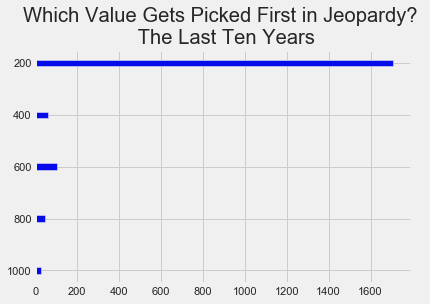

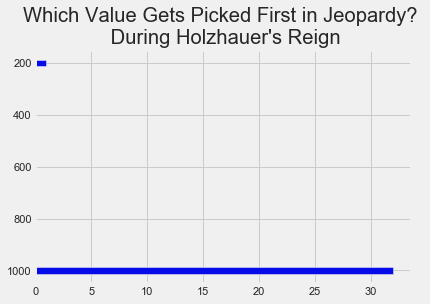

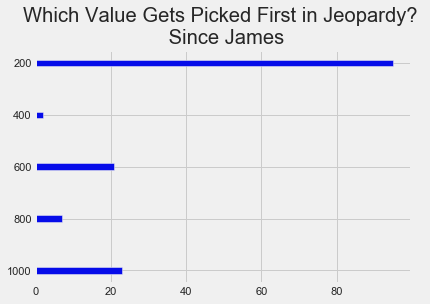

In [740]:
thejround()

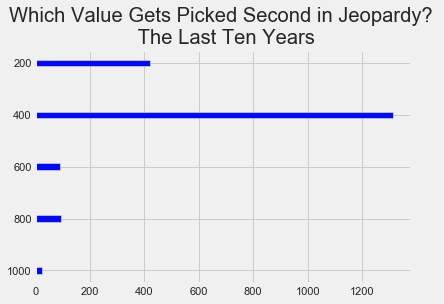

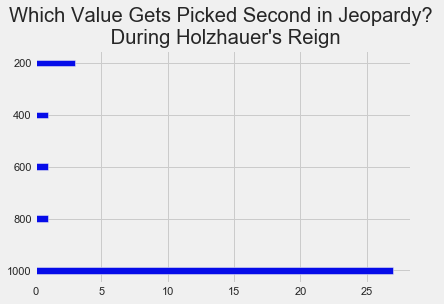

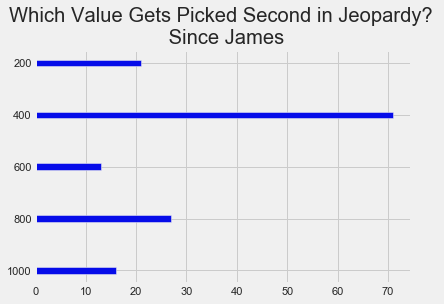

In [744]:
thejround(2)

In [745]:
pjdub = prejames[prejames['round_name']=='Jeopardy']
pjfirst = pjdub[pjdub['order']==2]
countsdub = pjfirst['value'].value_counts()
countsdub

400.0     1314
200.0      423
800.0       94
600.0       92
1000.0      26
Name: value, dtype: int64

In [748]:
1314/sum(countsdub)

0.6741918932786044

In [749]:
423/sum(countsdub)

0.21703437660338634

In [750]:
pjdub = thisyearsgames[thisyearsgames['round_name']=='Jeopardy']
pjfirst = pjdub[pjdub['order']==2]
countsdub = pjfirst['value'].value_counts()
countsdub

400.0     71
800.0     27
200.0     21
1000.0    16
600.0     13
Name: value, dtype: int64

In [751]:
98/sum(countsdub)

0.6621621621621622

In [752]:
#A permanent index of all the clue values to appear: 
pjdub = prejames[prejames['round_name']=='Double Jeopardy']
pjfirst = pjdub[pjdub['order']==1]
countsdub = pjfirst['value'].value_counts()
dubroundytix = countsdub.sort_index()

def doublejround(picknum=1):
#PRE JAMES FIRST CLUE DOUBLE JEOPARDY ROUND

    if picknum == 1:
        selection = 'First'
    elif picknum == 2:
        selection = 'Second'
    elif picknum == 3:
        selection = 'Third'
    else:
        selection = '%dth' % picknum
        
    pjdub = prejames[prejames['round_name']=='Double Jeopardy']

    pjfirst = pjdub[pjdub['order']==picknum]
    countsdub = pjfirst['value'].value_counts()
    countsdub = countsdub.sort_index()

    # Create bars
    fig, ax = plt.subplots()
    ax.barh(countsdub.index, countsdub, color = '#060CE9', height = 50)

    # Create names on the x-axis
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.yticks(dubroundytix.index)

    plt.ylim(top=150)  
    plt.ylim(bottom=2050) 

    titleone = 'Which Value Gets Picked %s in Double Jeopardy? \n The Last Ten Years' % selection
    
    ax.set_title(titleone)
    # Show graphic
    plt.show()

    #JAMES FIRST CLUE DOUBLE JEOPARDY ROUND
    jdub = jamesgames[jamesgames['round_name']=='Double Jeopardy']

    jfirst = jdub[jdub['order']==picknum]
    countsdub = jfirst['value'].value_counts()
    countsdub = countsdub.sort_index()

    # Create bars
    fig, ax = plt.subplots()
    ax.barh(countsdub.index, countsdub, color = '#060CE9', height = 50)

    # Create names on the x-axis
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.yticks(dubroundytix.index)

    plt.ylim(top=150) 
    plt.ylim(bottom=2050) 

    titletwo = 'Which Value Gets Picked %s in Double Jeopardy? \n During Holzhauer\'s Reign' % selection
    
    ax.set_title(titletwo)
    # Show graphic
    plt.show()


    #POST JAMES FIRST CLUE DOUBLE JEOPARDY ROUND
    postjdub = thisyearsgames[thisyearsgames['round_name']=='Double Jeopardy']

    postjfirst = postjdub[postjdub['order']==picknum]
    countsdub = postjfirst['value'].value_counts()
    countsdub = countsdub.sort_index()

    # Create bars
    fig, ax = plt.subplots()
    ax.barh(countsdub.index, countsdub, color = '#060CE9', height = 50)

    # Create names on the x-axis
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.yticks(dubroundytix.index)

    plt.ylim(top=150)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=2050) 

    titlethree = 'Which Value Gets Picked %s in Double Jeopardy? \n Since James' % selection
    
    ax.set_title(titlethree)
    # Show graphic
    plt.show()

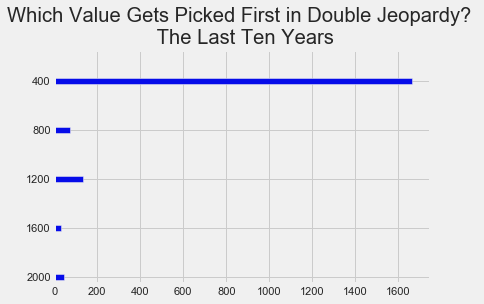

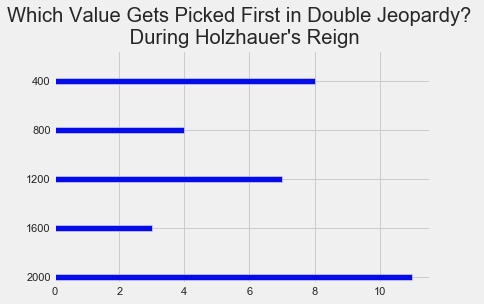

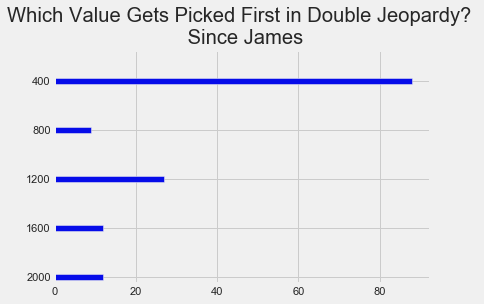

In [753]:
doublejround()

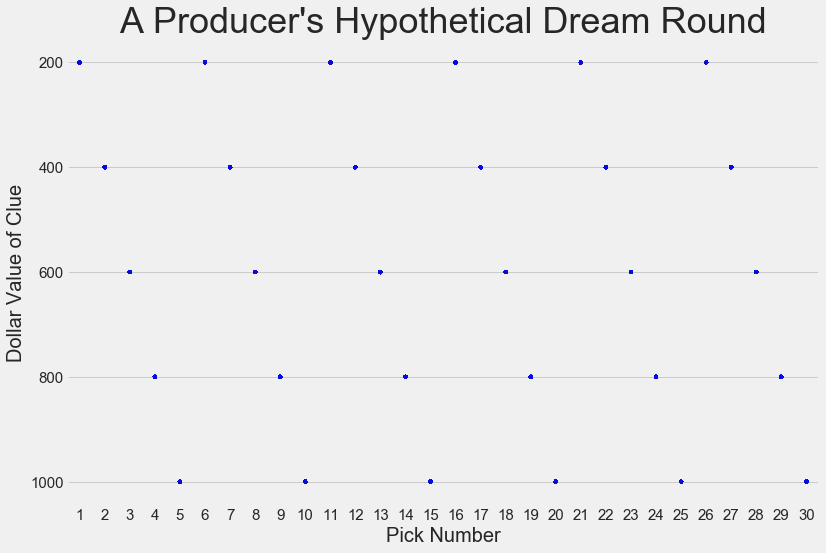

In [754]:
#Hypothetical round
tygfirst = recentprejames[recentprejames['round_name']=='Jeopardy']
firstdummy = tygfirst[(tygfirst['value'] == 200) & (tygfirst['order'].isin([1,6,11,16,21,26]))]
seconddummy = tygfirst[(tygfirst['value']==400) & (tygfirst['order'].isin([2,7,12,17, 22, 27]))]
thirddummy = tygfirst[(tygfirst['value']==600) & (tygfirst['order'].isin([3, 8, 13, 18, 23, 28]))]
fourthdummy = tygfirst[(tygfirst['value']==800) & (tygfirst['order'].isin([4, 9, 14, 19, 24, 29]))]
fifthdummy = tygfirst[(tygfirst['value']==1000) & (tygfirst['order'].isin([5, 10, 15, 20, 25, 30]))]
#boxplot = tygfirst.boxplot(column=['value'])

frames = [firstdummy, seconddummy, thirddummy, fourthdummy, fifthdummy]
producers = pd.concat(frames)

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)

bplot=sns.stripplot(y='value', x='order', 
                   data=producers, 
                   jitter=False, 
                   marker='o', 
                   alpha=0.002, 
                    color = '#060CE9')

#bplot.set_title('Which Clues Get Picked When? \n Jeopardy Rounds in Holzhauer Games')
#bplot.xlabel('Testing')
#bplot.set(xlabel='Pick Number', ylabel='Dollar Value of Clue')
#sns.set(font_scale = 1)

sns.set()
bplot.set(yticks = [200, 400, 600, 800, 1000])
bplot.axes.set_title("A Producer's Hypothetical Dream Round",fontsize=36)
bplot.set_xlabel("Pick Number",fontsize=20)
bplot.set_ylabel("Dollar Value of Clue",fontsize=20)
bplot.tick_params(labelsize=15)
#bplot.set_xticklabels(bplot.get_yticks(), size = 1)
bplot.invert_yaxis()

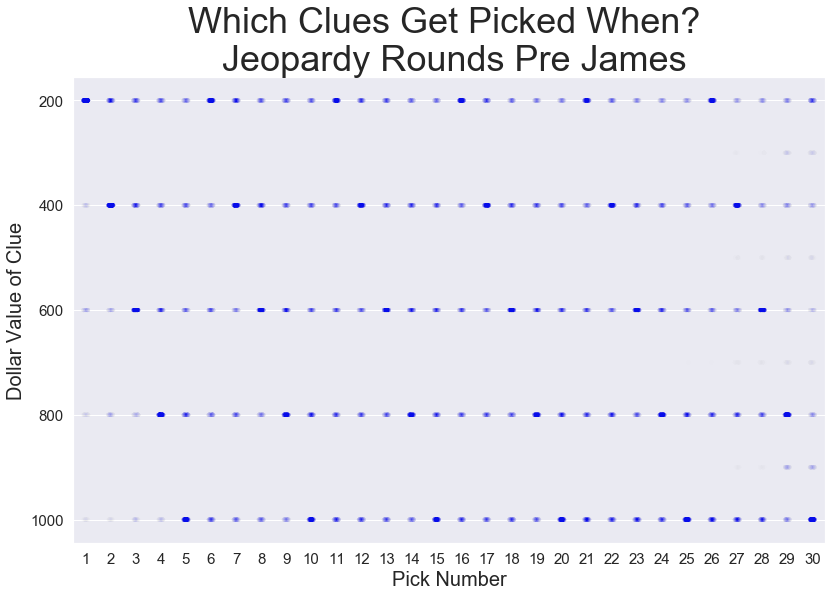

In [755]:
#The five years prior to James
tygfirst = recentprejames[recentprejames['round_name']=='Jeopardy']
#boxplot = tygfirst.boxplot(column=['value'])

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)

bplot=sns.stripplot(y='value', x='order', 
                   data=tygfirst, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.002, 
                    color = '#060CE9')

#bplot.set_title('Which Clues Get Picked When? \n Jeopardy Rounds in Holzhauer Games')
#bplot.xlabel('Testing')
#bplot.set(xlabel='Pick Number', ylabel='Dollar Value of Clue')
#sns.set(font_scale = 1)

sns.set()
bplot.set(yticks = [200, 400, 600, 800, 1000])
bplot.axes.set_title("Which Clues Get Picked When? \n Jeopardy Rounds Pre James",fontsize=36)
bplot.set_xlabel("Pick Number",fontsize=20)
bplot.set_ylabel("Dollar Value of Clue",fontsize=20)
bplot.tick_params(labelsize=15)
#bplot.set_xticklabels(bplot.get_yticks(), size = 1)
bplot.invert_yaxis()

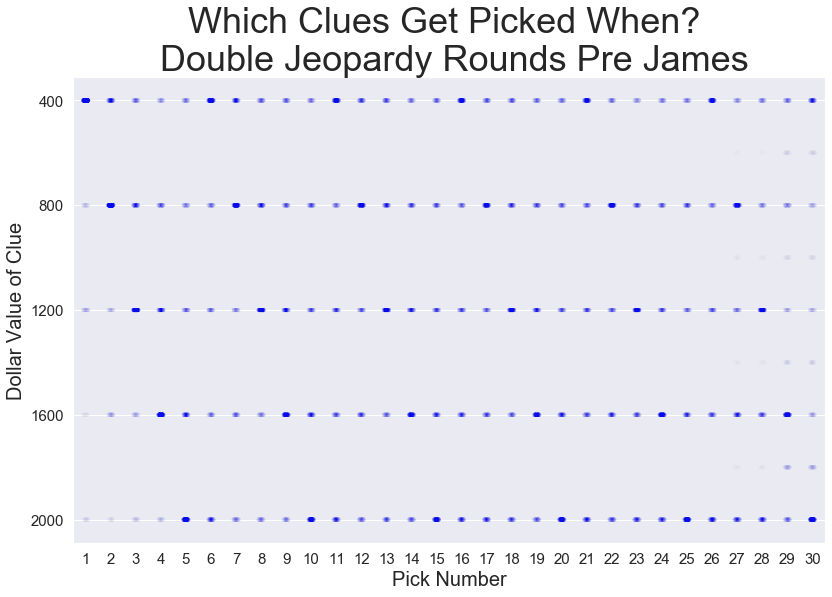

In [756]:
#The five years prior to James
tygfirst = recentprejames[recentprejames['round_name']=='Double Jeopardy']
#boxplot = tygfirst.boxplot(column=['value'])

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)

bplot=sns.stripplot(y='value', x='order', 
                   data=tygfirst, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.002, 
                    color = '#060CE9')

#bplot.set_title('Which Clues Get Picked When? \n Jeopardy Rounds in Holzhauer Games')
#bplot.xlabel('Testing')
#bplot.set(xlabel='Pick Number', ylabel='Dollar Value of Clue')
#sns.set(font_scale = 1)

sns.set()
bplot.set(yticks = [400, 800, 1200, 1600, 2000])
bplot.axes.set_title("Which Clues Get Picked When? \n Double Jeopardy Rounds Pre James",fontsize=36)
bplot.set_xlabel("Pick Number",fontsize=20)
bplot.set_ylabel("Dollar Value of Clue",fontsize=20)
bplot.tick_params(labelsize=15)
#bplot.set_xticklabels(bplot.get_yticks(), size = 1)
bplot.invert_yaxis()

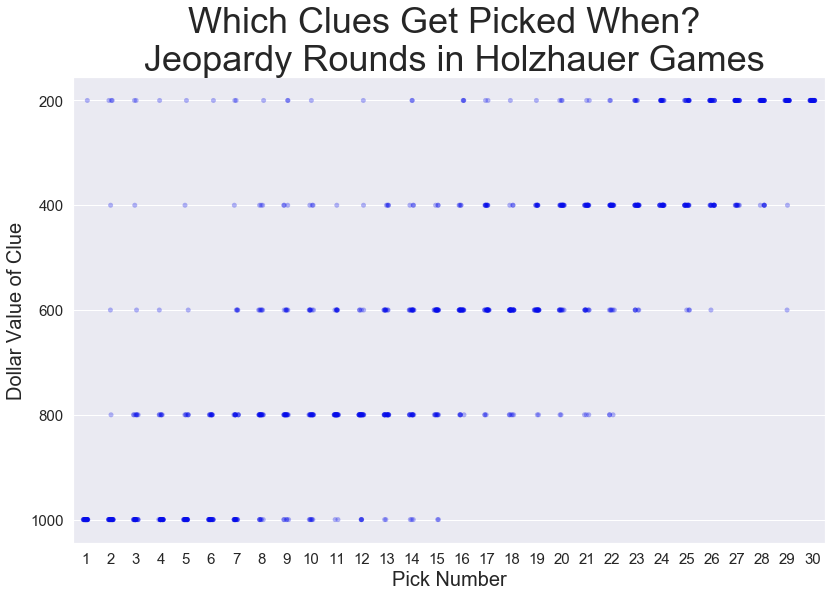

In [757]:
tygfirst = jamesgames[jamesgames['round_name']=='Jeopardy']
#boxplot = tygfirst.boxplot(column=['value'])

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)

bplot=sns.stripplot(y='value', x='order', 
                   data=tygfirst, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.3, 
                    color = '#060CE9')

#bplot.set_title('Which Clues Get Picked When? \n Jeopardy Rounds in Holzhauer Games')
#bplot.xlabel('Testing')
#bplot.set(xlabel='Pick Number', ylabel='Dollar Value of Clue')
#sns.set(font_scale = 1)

sns.set()
bplot.set(yticks = [200, 400, 600, 800, 1000])
bplot.axes.set_title("Which Clues Get Picked When? \n Jeopardy Rounds in Holzhauer Games",fontsize=36)
bplot.set_xlabel("Pick Number",fontsize=20)
bplot.set_ylabel("Dollar Value of Clue",fontsize=20)
bplot.tick_params(labelsize=15)
#bplot.set_xticklabels(bplot.get_yticks(), size = 1)
bplot.invert_yaxis()

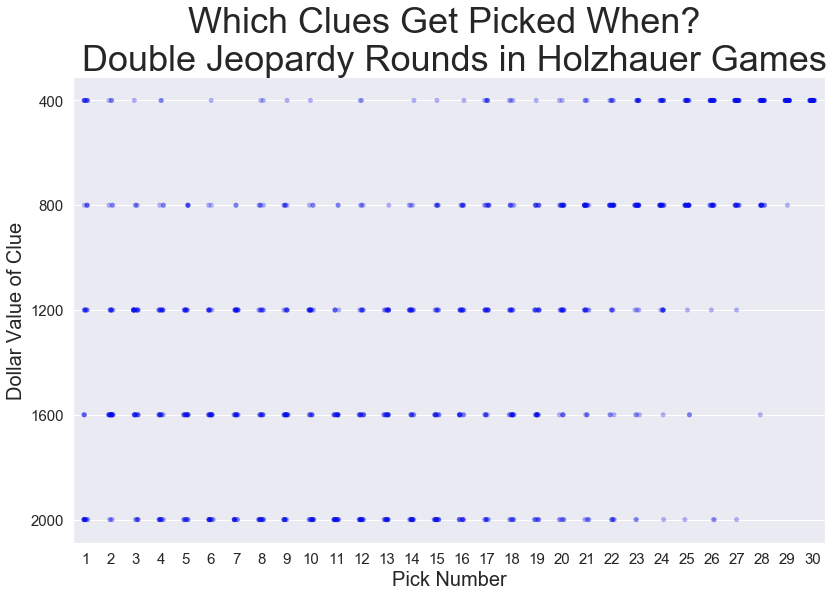

In [758]:
tygfirst = jamesgames[jamesgames['round_name']=='Double Jeopardy']
#boxplot = tygfirst.boxplot(column=['value'])

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)

bplot=sns.stripplot(y='value', x='order', 
                   data=tygfirst, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.3, 
                    color = '#060CE9')

#bplot.set_title('Which Clues Get Picked When? \n Jeopardy Rounds in Holzhauer Games')
#bplot.xlabel('Testing')
#bplot.set(xlabel='Pick Number', ylabel='Dollar Value of Clue')
#sns.set(font_scale = 1)

sns.set()
bplot.set(yticks = [400, 800, 1200, 1600, 2000])
bplot.axes.set_title("Which Clues Get Picked When? \n Double Jeopardy Rounds in Holzhauer Games",fontsize=36)
bplot.set_xlabel("Pick Number",fontsize=20)
bplot.set_ylabel("Dollar Value of Clue",fontsize=20)
bplot.tick_params(labelsize=15)
#bplot.set_xticklabels(bplot.get_yticks(), size = 1)
bplot.invert_yaxis()

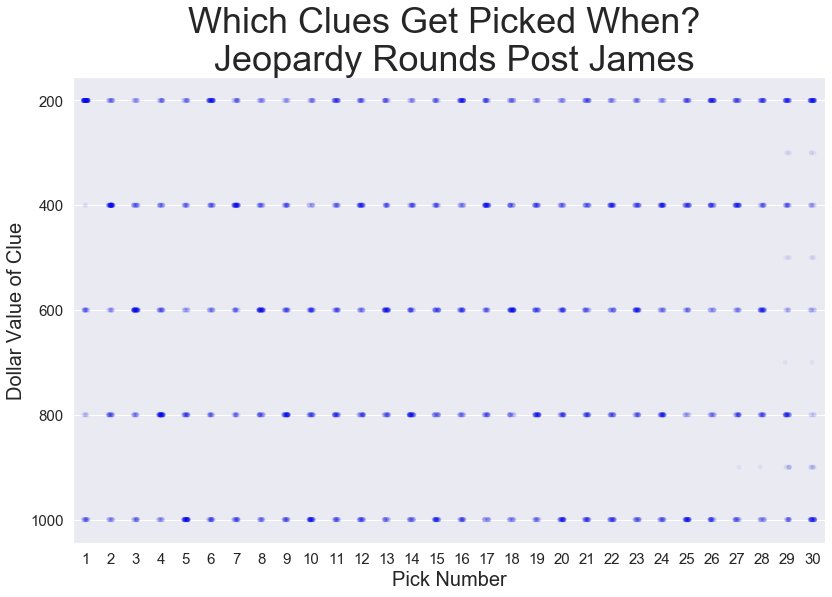

In [759]:
tygfirst = thisyearsgames[thisyearsgames['round_name']=='Jeopardy']
#boxplot = tygfirst.boxplot(column=['value'])

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)

bplot=sns.stripplot(y='value', x='order', 
                   data=tygfirst, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.05, 
                    color = '#060CE9')

#bplot.set_title('Which Clues Get Picked When? \n Jeopardy Rounds Since Holzhauer')
#bplot.xlabel('Testing')
#bplot.set(xlabel='Pick Number', ylabel='Dollar Value of Clue')
#sns.set(font_scale = 1)

sns.set()
bplot.set(yticks = [200, 400, 600, 800, 1000])
bplot.axes.set_title("Which Clues Get Picked When? \n Jeopardy Rounds Post James",fontsize=36)
bplot.set_xlabel("Pick Number",fontsize=20)
bplot.set_ylabel("Dollar Value of Clue",fontsize=20)
bplot.tick_params(labelsize=15)
#bplot.set_xticklabels(bplot.get_yticks(), size = 1)
bplot.invert_yaxis()

In [767]:
print(sum(thisyearsgames[thisyearsgames['daily_double']==True]['correctAttempts']))

278


In [768]:
print(thisyearsgames[thisyearsgames['daily_double']==True]['correctAttempts'].shape[0])
print(sum(thisyearsgames[thisyearsgames['daily_double']==True]['correctAttempts'])/thisyearsgames[thisyearsgames['daily_double']==True]['correctAttempts'].shape[0])

439
0.6332574031890661


In [769]:
71/75

0.9466666666666667

In [770]:
recentprejames = prejames[prejames['epNum']>=6666]

In [771]:
print("Before James: ")
filteredone = recentprejames[recentprejames['order']==1]
roundone = filteredone[filteredone['round_name']=='Jeopardy']
roundtwo = filteredone[filteredone['round_name']=='Double Jeopardy']
print(sum(roundone['correctAttempts']) / roundone.shape[0])
print(sum(roundtwo['correctAttempts']) / roundtwo.shape[0])

print("During James: ")
filteredone = jamesgames[jamesgames['order']==1]
roundone = filteredone[filteredone['round_name']=='Jeopardy']
roundtwo = filteredone[filteredone['round_name']=='Double Jeopardy']
print(sum(roundone['correctAttempts']) / roundone.shape[0])
print(sum(roundtwo['correctAttempts']) / roundtwo.shape[0])

print("After James: ")
filteredone = thisyearsgames[thisyearsgames['order']==1]
roundone = filteredone[filteredone['round_name']=='Jeopardy']
roundone = roundone[roundone['value']==1000]
roundtwo = filteredone[filteredone['round_name']=='Double Jeopardy']
roundtwo = roundtwo[roundtwo['value']==2000]
print(sum(roundone['correctAttempts']) / roundone.shape[0])
print(roundone.shape[0])
print(sum(roundtwo['correctAttempts']) / roundtwo.shape[0])
print(roundtwo.shape[0])

Before James: 
0.945324881141046
0.9286846275752774
During James: 
0.9090909090909091
0.8787878787878788
After James: 
0.7391304347826086
23
0.9166666666666666
12


In [772]:
roundone = recentprejames[recentprejames['round_name']=='Jeopardy']
roundone = roundone[roundone['value']==1000]
#roundtwo = filteredone[filteredone['round_name']=='Double Jeopardy']
print(sum(roundone['correctAttempts']) / roundone.shape[0])
#print(sum(roundtwo['correctAttempts']) / roundtwo.shape[0])

0.7890318212593094


In [ ]:
filteredone = thisyearsgames[thisyearsgames['order']==1]
roundone = filteredone[filteredone['round_name']=='Jeopardy']
firstpick = roundone[roundone['value']==1000]

filteredtwo = thisyearsgames[thisyearsgames['order']==2]
roundone = filteredtwo[filteredtwo['round_name']=='Jeopardy']
secondpick = roundone[roundone['value']==1000]

result = pd.concat([firstpick, secondpick])
result = result.sort_values(by=['epNum'])
mycounts = result.groupby('epNum').count()
theseones = mycounts[mycounts['airDate'] == 2]
result[result['epNum'].isin(theseones.index.tolist())]